In [414]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import numpy as np

def detect_outliers_iqr(data):
    # Compute the first and third quartiles
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    
    # Identify outliers
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.barplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.6, 
        capsize=0.1, 
        linewidth=1
    )
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=True, 
        jitter=0.5, 
        alpha=1,  
        order=order, 
        palette=palette,
        size=3.5
    )


    # Shift the stripplot points slightly to the left.
    shift = 0.1  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        if i == 0:
            shift = 0.7
        elif i == 1:
            shift = 0.05
        elif i == 2:
            shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                        verbose=2, show_test_name=False)
    annotator.apply_and_annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1.5)

    return ax

In [415]:
# load data
data = pd.read_csv('../../elisa_data/ABCA7_spheroid_Abeta ELISA_011125_4Week.csv', index_col=0)
data_subset = data[(data['Line'] != 'G2') & (data['Line'] != 'Y+500uM')]
data_subset.columns = ['line', 'x', 'y', 'Abeta42', 'Abeta40', 'Abeta42/40']
data_subset.index = np.arange(len(data_subset))

In [416]:
# Remove outliers (significant also when not doing so, but makes it very difficult to plot otherwise)
outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta40'].values)
data_40 = data_subset[np.invert(outliers)]

outliers, lb, ub = detect_outliers_iqr(data_subset['Abeta42'].values)
data_42 = data_subset[np.invert(outliers)]


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_85730/846485318.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sp = sns.stripplot(
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_85730/846485318.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sp = sns.stripplot(
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: Futur

E3 vs. y622: t-test independent samples, P_val:4.635e-04 t=-3.842e+00
y622 vs. Y+1mM: t-test independent samples, P_val:4.381e-02 t=2.102e+00
E3 vs. y622: t-test independent samples, P_val:1.851e-04 t=-4.154e+00
y622 vs. Y+1mM: t-test independent samples, P_val:1.737e-03 t=3.428e+00


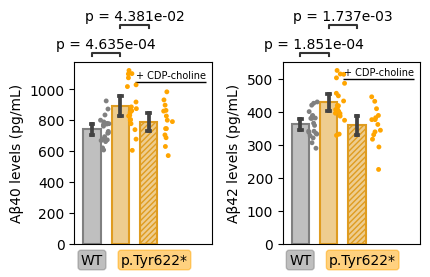

In [417]:
# plot 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.4, 3))

# Set current axis to ax1 before calling your function for the first plot.
plt.sca(ax1)
ax1 = plot_boxplot_by_treatment(
    data_40, 
    x_val='line', 
    y_val='Abeta40',   # adjust if necessary
    order=['E3', 'y622', 'Y+1mM'], 
    pairs=[('E3', 'y622'), ('y622', 'Y+1mM')], 
    palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'orange'}
)
ax1.set_ylabel('Aβ40 levels (pg/mL)')

# Add horizontal line and CDP-choline text for the first plot
ax1.hlines(y=1050, xmin=1.5, xmax=4, linestyles='solid', color='black', linewidth=1)
ax1.text(4, 1070, '+ CDP-choline', ha='right', fontsize=7)

ax1.set_xticks([])

# Add custom x-axis labels for the first plot:
ax1.text(0, -0.05, "WT", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5))
ax1.text(2.2, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5))

# Add hatch to the last bar of the first plot
if ax1.patches:
    last_patch = ax1.patches[-1]
    last_patch.set_hatch('//////')

# Set current axis to ax2 before calling your function for the second plot.
plt.sca(ax2)
ax2 = plot_boxplot_by_treatment(
    data_42, 
    x_val='line', 
    y_val='Abeta42', 
    order=['E3', 'y622', 'Y+1mM'], 
    pairs=[('E3', 'y622'), ('y622', 'Y+1mM')], 
    palette={'E3': 'grey', 'y622': 'orange', 'Y+1mM': 'orange'}
)
ax2.set_ylabel('Aβ42 levels (pg/mL)')

# Add horizontal line and CDP-choline text for the second plot
ax2.hlines(y=500, xmin=1.5, xmax=4, linestyles='solid', color='black', linewidth=1)
ax2.text(4, 510, '+ CDP-choline', ha='right', fontsize=7)

ax2.set_xticks([])

# Add custom x-axis labels for the second plot:
ax2.text(0, -0.05, "WT", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5))
ax2.text(2.2, -0.05, "p.Tyr622*", ha='center', va='top', transform=ax2.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5))

# Add hatch to the last bar of the second plot
if ax2.patches:
    last_patch = ax2.patches[-1]
    last_patch.set_hatch('//////')

plt.tight_layout()

plt.savefig('../../paper/main_plots/abeta_elisa.png')
plt.show()
